# Automatic Feature Importances & selection

Feature importances are an important topic in machine learning because they help us understand which features (or variables) are the most important in predicting the target variable. Feature importance is the process of determining which features contribute most to the accuracy of a machine learning model. By understanding the importance of each feature, we can identify which variables have the most impact on the model's predictions and make better decisions about feature selection, model building, and problem-solving.



- Data-based feature importances strategies
- Model-based feature importance strategies
- Automatic comparing strategy for feature importances
- Automatic feature selection algorithm

In [2]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

## Datasets

### Wine Quality Dataset


The Wine Quality Dataset involves predicting the quality of white wines on a scale given chemical measures of each wine.

It is a multi-class classification problem, but could also be framed as a regression problem. The number of observations for each class is not balanced. There are 4,898 observations with 11 input variables and one output variable. The variable names are as follows:



- Fixed acidity.
- Volatile acidity.
- Citric acid.
- Residual sugar.
- Chlorides.
- Free sulfur dioxide.
- Total sulfur dioxide.
- Density.
- pH.
- Sulphates.
- Alcohol.
- Quality (score between 0 and 10).

In [3]:
wine_data = pd.read_csv('winequality-white.csv', delimiter=';')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Data-based Feature Importances Strategies


The simplest technique to identify important regression features is to rank them by their correlation coefficient; the feature with the largest coefficient is taken to be the most important.

## Correlation

In [5]:
def top_rank_corr_based(df, target, n=None, ascending=False, method='spearman'):
    """
    Calculate first / last N correlation with target
    This kind of importance is called single-feature relevance importance
    But suffers in the presence of codependent features.
    Groups of features with similar relationships to the response variable receive the same or similar ranks, 
    even though just one should be considered important.
    pearson : standard correlation coefficient
    kendall : Kendall Tau correlation coefficient
    spearman : Spearman rank correlation
    :return:
    """
    if not n:
        n = len(df.columns)
    feas = list(abs(df.corr(method=method)[target]).sort_values(ascending=ascending).index[1:n+1])
    vals = list(abs(df.corr(method=method)[target]).sort_values(ascending=ascending))[1:n+1]
    return feas, vals

In [89]:
def list_to_pd(fea,val):
    return pd.DataFrame({'Feature':fea,'Feature_importance':val})

def plot_feat_imp(df):
    ordered_df = df.sort_values(by='Feature_importance',ascending=True).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(8,6))
    my_range = range(1, len(df.index) + 1)

    ax.hlines(y=my_range, xmin=0, xmax=ordered_df['Feature_importance'],
               color='blue')
    for i,val in enumerate(ordered_df.Feature_importance):
        if np.sign(val)==1:
            ax.annotate(f"{val:0.3f}", (val + 0.002, i+1+0.1), size=11, annotation_clip=False)
        else:
            ax.annotate(f"{val:0.3f}", (val - 0.002, i+1+0.1), size=11, annotation_clip=False)
    ax.scatter(ordered_df['Feature_importance'], my_range, marker = 'o')
    ax.set_yticks(ordered_df.index+1)
    ax.set_yticklabels(labels = ordered_df.Feature.values,fontsize=12)
    ax.set_xlabel('Feature Importance',fontsize=12)
    if np.sign(min(ordered_df.Feature_importance))==1:
        ax.set_xlim(min(ordered_df.Feature_importance)-min(ordered_df.Feature_importance),max(ordered_df.Feature_importance)+max(ordered_df.Feature_importance)*0.5)
    else:
        ax.set_xlim(min(ordered_df.Feature_importance)+min(ordered_df.Feature_importance),max(ordered_df.Feature_importance)+max(ordered_df.Feature_importance)*0.5)
    return plt


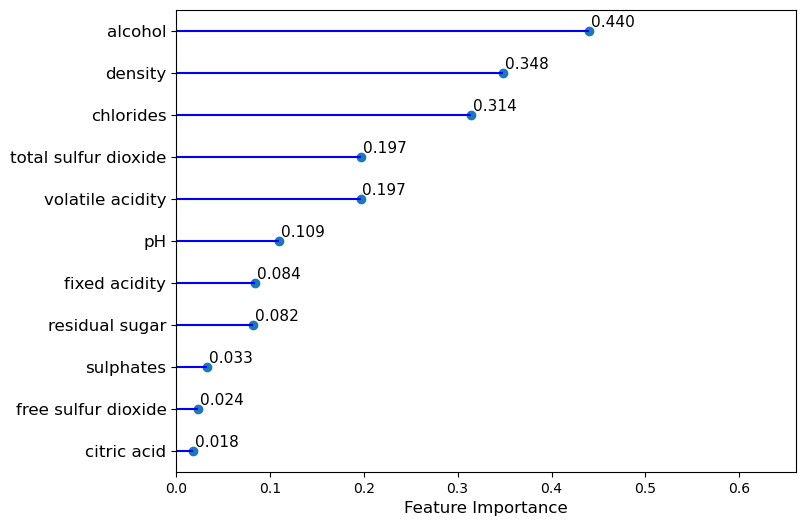

In [90]:
feas, vals = top_rank_corr_based(wine_data,'quality',method='spearman')
df = list_to_pd(feas,vals)
plot_feat_imp(df).show()

## PCA

Another possibility is to use principle component analysis (PCA), which operates on just the X explanatory matrix. PCA transforms data into a new space characterized by eigenvectors and identifies features that explain the most variance in the new space. If the first principal component covers a large percentage of the variance, the "loads" associated with that component can indicate importance of features in the original X space.

In [91]:
def top_rank_PCA_based(df, target, n=None, ascending=False):
    if not n:
        n = len(df.columns)
    scaler = StandardScaler()
    feas = [col for col in df.columns if col != target]
    X = scaler.fit_transform(df.loc[:, feas])
    pca = PCA(n_components=0.9)
    pca.fit(X)
    featimp = {feas[i]:abs(pca.components_[0])[i] for i in range(len(feas))}
    feas = sorted(featimp, key=featimp.get, reverse=True)[:n]
    vals = [featimp[fea] for fea in feas]
    return feas, vals

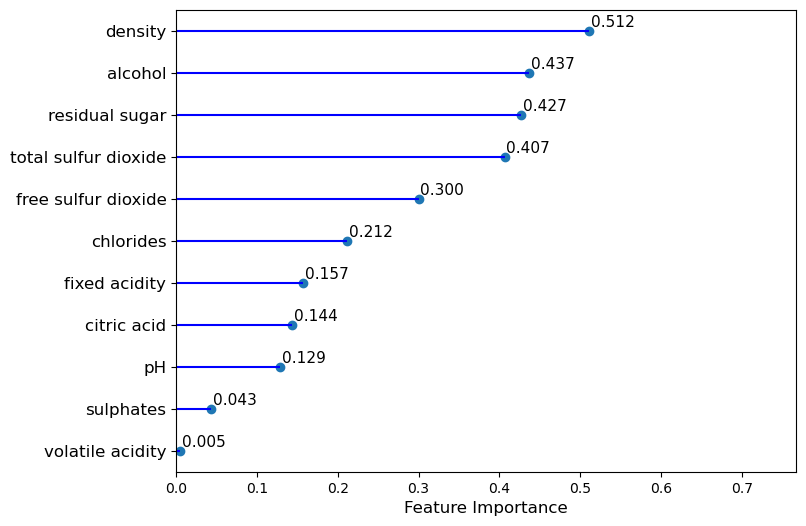

In [92]:
feas, vals = top_rank_PCA_based(wine_data,'quality')
df = list_to_pd(feas,vals)
plot_feat_imp(df).show()

## Minimal-redundancy-maximal-relevance (mRMR)

This algorithm tends to select a subset of features having the most correlation with the class (output) and the least correlation between themselves. It ranks features according to the minimal-redundancy-maximal-relevance criterion which is based on mutual information

- Relevance: The coefficient between the individual feature and the target
- Redundancy: The coefficient between each individual feature.

In [93]:
def mRMR(df, target, mode='spearman', n=None, info=False):
    if not n:
        n = len(df.columns)
    mrmr = dict()
    
    # use different mode to calculate correaltion
    feas, imps = top_rank(df, target, method=mode)
    corr = dict([(fea, imp) for imp, fea in zip(imps, feas)])
    selected_feat = [feas[0]]
    
    for i in range(len(feas)):
        rest_feat = [col for col in feas if col not in selected_feat]
        if not len(rest_feat):
            break
        candi_mrmr = []
        for fi in rest_feat:
            redundancy = 0
            relevance = corr[fi]
            for fj in selected_feat:
                feas, imps = top_rank(df.drop(columns=target), fj, method=mode)
                corr_fj = dict([(fea, imp) for imp, fea in zip(imps, feas)])
                redundancy += corr_fj[fi]
            redundancy /= len(selected_feat)
            candi_mrmr.append(relevance - redundancy)
        max_feature = rest_feat[np.argmax(candi_mrmr)]
        mrmr[max_feature] = np.max(candi_mrmr)
        if info:
            print(f'{i+1} iteration, selected {max_feature} feature with mRMR value = {mrmr[max_feature]:.3f}')
        selected_feat.append(max_feature)
    feat_imp = pd.Series(mrmr.values(), index=mrmr.keys()).sort_values(ascending=False)
    return feat_imp.index[:n],feat_imp.values[:n]

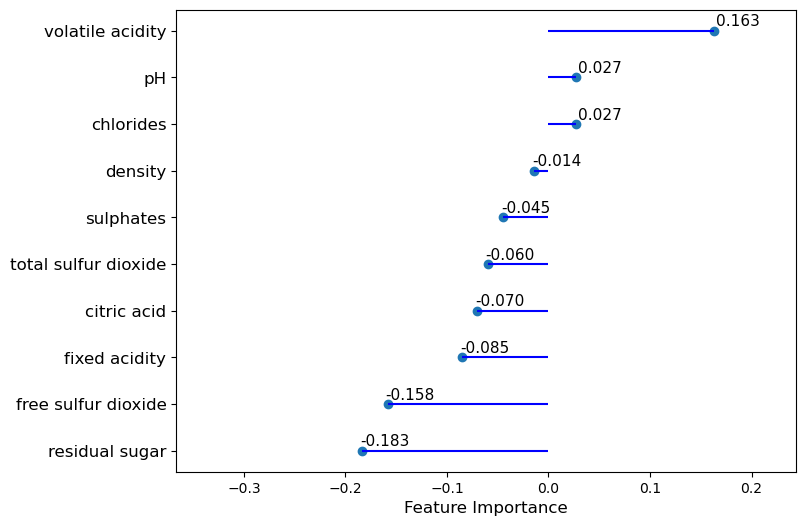

In [94]:
feas, vals = mRMR(wine_data,'quality')
df = list_to_pd(feas,vals)
plot_feat_imp(df).show()

## Model based feature importance


Model based feature importance involves fitting a model such as random forest to all the features and finding the relation between feature and the response variable. The importances obtained will be dependant on the model chosen and the accuracy of our model fit. Some of the methods that we will try involve:


- Permutation importances
- Drop column importances

## Permutation Importance

 It works by shuffling the values of a single feature in the dataset and measuring the resulting decrease in the model's performance metric, such as accuracy, precision, or recall.

The permutation feature importance technique calculates the importance of a feature by comparing the original model performance with the performance of the model after shuffling the values of that feature. A feature is considered more important if shuffling its values leads to a larger decrease in the model's performance.

Permutation feature importance is a model-agnostic technique and can be applied to any type of model, including linear regression, logistic regression, decision trees, and neural networks. It is a popular method for feature selection, as it can identify the most relevant features in a dataset and help to reduce the dimensionality of the input space, leading to simpler and more interpretable models.

In [98]:
def rf_model(x_train, y_train):
    rf = RandomForestRegressor(n_estimators=30,
                             min_samples_leaf=80,
                             max_features=0.5,
                             max_depth=10,
                             oob_score=True,
                             n_jobs=-1)

    rf.fit(x_train, y_train)
    return rf

In [99]:
# Model-based importance strategies
def permutation_importance(X_train, y_train, X_valid, y_valid):
    model = rf_model(X_train, y_train)
    baseline = r2_score(y_valid, model.predict(X_valid))
    imp = []
    for col in X_valid.columns:
        save = X_valid[col].copy()
        X_valid[col] = np.random.permutation(X_valid[col])
        m = r2_score(y_valid, model.predict(X_valid))
        X_valid[col] = save
        imp.append(baseline - m)
    feat_imp = pd.Series(imp, index=X_valid.columns).sort_values(ascending=False)
    return feat_imp.index,feat_imp.values


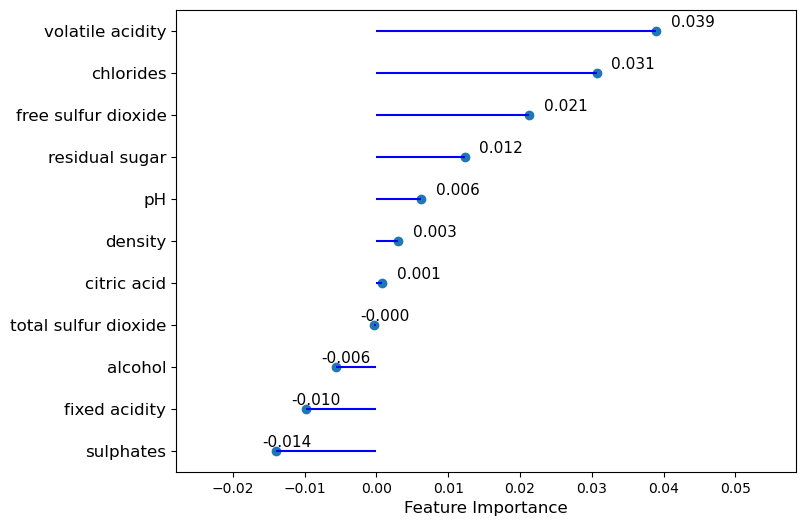

In [100]:
def train_val_split(df, ratio):
    train, val = train_test_split(df, train_size=ratio, shuffle=True)
    return train, val

def split_target(df, target):
    Y = df[target].values
    X = df.drop(columns=[target])
    return X, Y

X,Y = split_target(wine_data,'quality')
X_train, X_val = train_val_split(X, 0.7)
Y_train, Y_val = train_val_split(Y, 0.7)
feas, vals = permutation_importance(X_train,Y_train,X_val,Y_val)
df = list_to_pd(feas,10*vals)
plot_feat_imp(df).show()

## Drop Column Importances


it's a technique similar to permutation importance, but with the new model trained with one column dropped to determine whether there is a difference in performance

In [103]:
def dropcol_importances(X_train, y_train, X_valid, y_valid):
    model = rf_model(X_train, y_train)
    baseline = model.oob_score_
    imp = []
    for col in X_train.columns:
        X_train_ = X_train.drop(col, axis=1)
        X_valid_ = X_valid.drop(col, axis=1)
        model_ = clone(model)
        model_.fit(X_train_, y_train)
        m = model_.oob_score_
        imp.append(baseline - m)
    feat_imp = pd.Series(imp, index=X_valid.columns).sort_values(ascending=False)
    return feat_imp.index,feat_imp.values

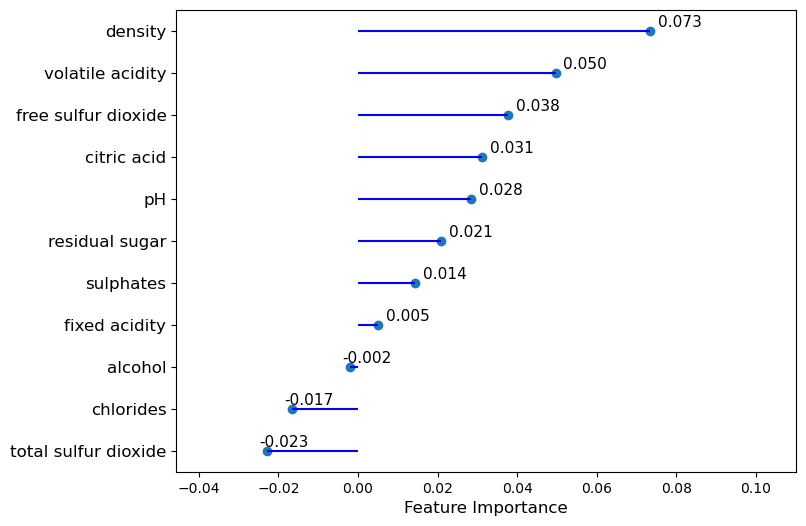

In [105]:
feas, vals = dropcol_importances(X_train,Y_train,X_val,Y_val)
df = list_to_pd(feas,10*vals)
plot_feat_imp(df).show()

## SHAP importance

Shapley Additive Explanations (SHAP) feature importance is a method used to explain the output of a machine learning model by attributing the importance of each input feature to the prediction.

It is based on game theory, specifically the Shapley value, which is a concept used to allocate rewards fairly among players in a cooperative game. In the context of machine learning, each feature can be seen as a player in a game, and the Shapley value measures the contribution of each feature to the model output.

The SHAP feature importance method calculates the average contribution of each feature to the model output across all possible permutations of features. By doing so, it provides a more accurate and reliable measure of feature importance than other methods, such as permutation feature importance or coefficient values in linear models.

The SHAP feature importance method is model-agnostic, meaning it can be used with any machine learning model, and it provides both global and local feature importance values. Global feature importance measures the importance of a feature across the entire dataset, while local feature importance measures the importance of a feature for a specific instance or prediction.



In [124]:
def shap_importances(x_train, y_train, x_val, y_val):
    rf = rf_model(x_train, y_train)
    shap_values = shap.TreeExplainer(rf, data=x_train).shap_values(X=x_val, y=y_val, check_additivity=False)
    imp = np.mean(np.abs(shap_values), axis=0)
    return  x_val.columns,imp

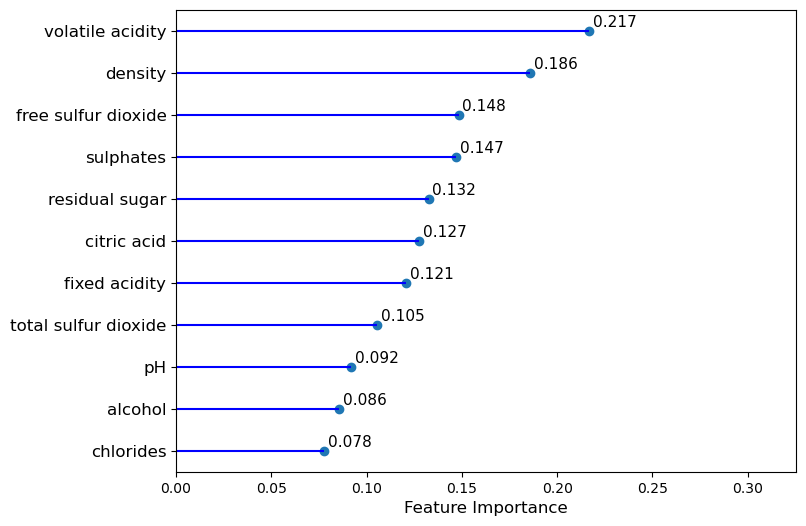

In [125]:
feas, vals = shap_importances(X_train,Y_train,X_val,Y_val)
df = list_to_pd(feas,10*vals)
plot_feat_imp(df).show()

## Compare different Strategies

The function below compares different strategies and draw a R2 score vs num of variables chosen plot.

In [143]:

# Comparing strategies
def Top_k_loss(x_train, y_train, x_val, y_val, feat, imp, k=10, metric=r2_score):
    model = rf_model(x_train, y_train)
    loss_list = []
    n_imp = pd.Series(imp, index=feat).sort_values(ascending=False)[:k]
    for i in range(1, k+1):
        model_ = clone(model)
        features = n_imp.index[:i]
        model_.fit(x_train.loc[:, features], y_train)
        pred = model_.predict(x_val.loc[:, features])
        loss = metric(y_val, pred)
        loss_list.append(loss)
    return loss_list


def compare_Top_k(data, target, k=10):
    train, val = train_val_split(data, 0.8)
    x_train, y_train = split_target(train, target)
    x_val, y_val = split_target(val, target)
    
    feat_spearman, imp_spearman = top_rank_corr_based(data, target, method='spearman')
    loss_spearman = Top_k_loss(x_train, y_train, x_val, y_val, feat_spearman, imp_spearman, k=k)
    feat_pearson, imp_pearson = top_rank_corr_based(data, target, method='pearson')
    loss_pearson = Top_k_loss(x_train, y_train, x_val, y_val, feat_pearson, imp_pearson, k=k)
    feat_kendall, imp_kendall = top_rank_corr_based(data, target, method='kendall')
    loss_kendall = Top_k_loss(x_train, y_train, x_val, y_val, feat_kendall, imp_kendall, k=k)
    feat_pca, imp_pca = top_rank_PCA_based(data, target)
    loss_pca = Top_k_loss(x_train, y_train, x_val, y_val, feat_pca, imp_pca)
    feat_perm, imp_perm= permutation_importance(x_train, y_train, x_val, y_val)
    loss_perm = Top_k_loss(x_train, y_train, x_val, y_val, feat_perm, imp_perm, k=k)
    feat_drop, imp_drop = dropcol_importances(x_train, y_train, x_val, y_val)
    loss_drop = Top_k_loss(x_train, y_train, x_val, y_val, feat_drop, imp_drop, k=k)
    feat_shap, imp_shap = shap_importances(x_train, y_train, x_val, y_val)
    loss_shap = Top_k_loss(x_train, y_train, x_val, y_val, feat_shap, imp_shap, k=k)
    feat_mrmr, imp_mrmr= mRMR(data, target)
    loss_mrmr = Top_k_loss(x_train, y_train, x_val, y_val, feat_mrmr, imp_mrmr, k=k)

    fig = plt.figure(figsize=(15,15))
    ax = plt.axes()
    ax.grid(False)
    x, markers = range(1, k+1), ['o', '8', 's', 'p', '+', '*', 'h', 'v']
    plt.plot(x, loss_spearman, '#BA5645', marker=markers[0],  label='Spearman')
    plt.plot(x, loss_pearson, '#BA8949', marker=markers[1],  label='Pearson')
    plt.plot(x, loss_kendall, '#8DBA49', marker=markers[2],  label='Kendall')
    plt.plot(x, loss_pca, '#49A7BA', marker=markers[3],  label='PCA')
    plt.plot(x, loss_perm, '#6E49BA', marker=markers[4],  label='Permutation')
    plt.plot(x, loss_drop, '#BA49A0', marker=markers[5],  label='Drop Column')
    plt.plot(x, loss_shap, '#878784', marker=markers[6],  label='Shap')
    plt.plot(x, loss_mrmr, '#000000', marker=markers[7],  label='mRMR')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylabel('R2 score', fontsize=10)
    ax.set_xlabel('Top K selected features', fontsize=10)
    plt.show()


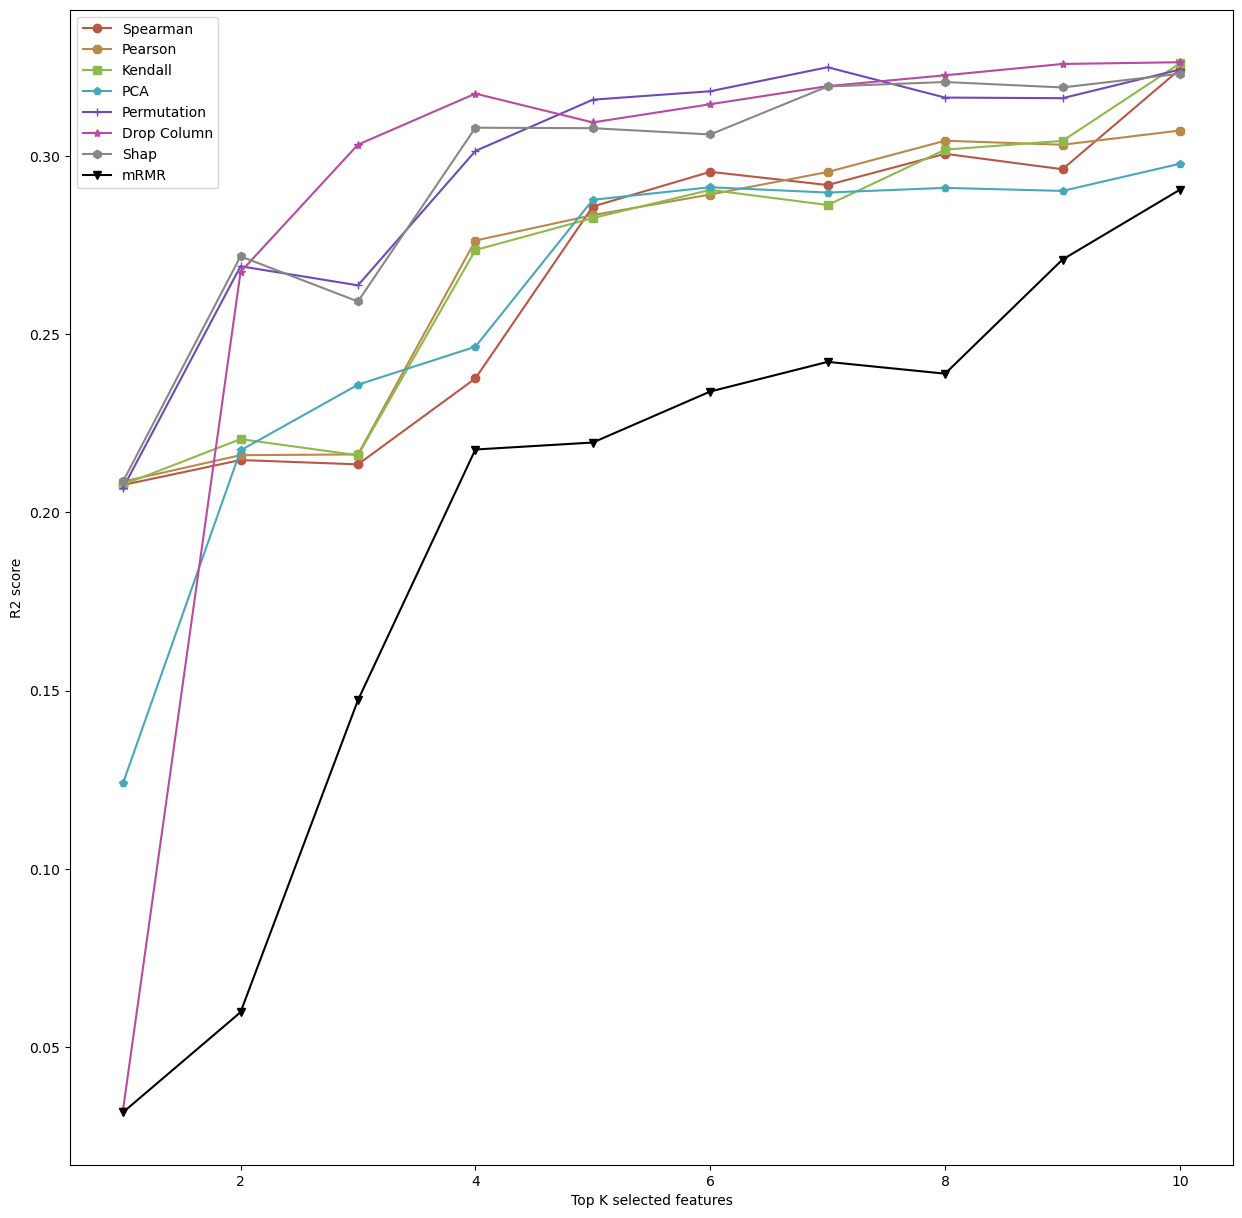

In [144]:
compare_Top_k(wine_data, 'quality', 10)